Задание взято из kaggle: https://www.kaggle.com/datasets/anikannal/solar-power-generation-data

В данной работе я хочу спрогнозировать временной ряд с суммарной генерацию энергии солнечными батареями за к моменту времени за день. <br>

Это может использоваться для: <br>
- Снижения затрат на энергию, за счет перехода на солнечную энергию в пик ее генерации
- Избежания дефицита энергии на автономных предприятиях
- Планирования цены энергии для продажи
- Расчет окупаемости в предприятии

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

from catboost import CatBoostRegressor

from statsmodels.tsa.stattools import adfuller, kpss

from statsmodels.tsa.statespace.sarimax import SARIMAX

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
plant_1_weather = pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_1_Weather_Sensor_Data.csv')
plant_1_generation = pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_1_Generation_Data.csv')
plant_2_weather = pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_2_Weather_Sensor_Data.csv')
plant_2_generation = pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_2_Generation_Data.csv')

В качестве метрик использовались MSE и MAE, тк эту задачу можно считать задачей регрессии.

В качестве бизнес метрик можно использовать:
- Затраты на электроэнергию
- Время без энергии
- Увеличение дохода
- Количество сохраненных денежных средств

# Анализ данных

In [3]:
plant_1_weather

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0
...,...,...,...,...,...,...
3177,2020-06-17 22:45:00,4135001,HmiyD2TTLFNqkNe,22.150570,21.480377,0.0
3178,2020-06-17 23:00:00,4135001,HmiyD2TTLFNqkNe,22.129816,21.389024,0.0
3179,2020-06-17 23:15:00,4135001,HmiyD2TTLFNqkNe,22.008275,20.709211,0.0
3180,2020-06-17 23:30:00,4135001,HmiyD2TTLFNqkNe,21.969495,20.734963,0.0


In [4]:
plant_1_generation

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.000,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.000,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.000,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.000,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.000,7158964.0
...,...,...,...,...,...,...,...
68773,17-06-2020 23:45,4135001,uHbuxQJl8lW7ozc,0.0,0.0,5967.000,7287002.0
68774,17-06-2020 23:45,4135001,wCURE6d3bPkepu2,0.0,0.0,5147.625,7028601.0
68775,17-06-2020 23:45,4135001,z9Y9gH1T5YWrNuG,0.0,0.0,5819.000,7251204.0
68776,17-06-2020 23:45,4135001,zBIq5rxdHJRwDNY,0.0,0.0,5817.000,6583369.0


In [5]:
plant_1_weather['DATE_TIME'] = pd.to_datetime(plant_1_weather['DATE_TIME'], dayfirst=True)

<ipython-input-5-bf94c2fc8507>:1: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  plant_1_weather['DATE_TIME'] = pd.to_datetime(plant_1_weather['DATE_TIME'], dayfirst=True)


In [6]:
plant_1_generation['DATE_TIME'] = pd.to_datetime(plant_1_generation['DATE_TIME'], dayfirst=True)

В данных содержатся сведения о нескольких солнечных панелях. Я хочу решить задачу прогнозирования генерируемой энергии для всех сразу, поэтому суммируем все значения для панелей.

In [7]:
plant1_data = pd.merge(plant_1_generation.groupby('DATE_TIME').sum(), plant_1_weather[['DATE_TIME', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']], on="DATE_TIME", how='left')
plant1_data.drop(['PLANT_ID', 'SOURCE_KEY'], inplace=True, axis=1)
plant1_data

,DATE_TIME,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,0.0,0.0,0.000000,143581676.0,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,0.0,0.0,0.000000,143581676.0,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,0.0,0.0,0.000000,143581676.0,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,0.0,0.0,0.000000,143581676.0,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,0.0,0.0,0.000000,150761642.0,24.621525,22.165423,0.0
...,...,...,...,...,...,...,...,...
3153,2020-06-17 22:45:00,0.0,0.0,129571.000000,156142755.0,22.150570,21.480377,0.0
3154,2020-06-17 23:00:00,0.0,0.0,129571.000000,156142755.0,22.129816,21.389024,0.0
3155,2020-06-17 23:15:00,0.0,0.0,129571.000000,156142755.0,22.008275,20.709211,0.0
3156,2020-06-17 23:30:00,0.0,0.0,129571.000000,156142755.0,21.969495,20.734963,0.0


In [8]:
plant1_data.describe()

,DATE_TIME,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
count,3158,3158.000000,3158.000000,3158.000000,3.158000e+03,3157.000000,3157.000000,3157.000000
mean,2020-06-01 06:42:44.344521728,68547.713729,6703.628149,71782.817545,1.519892e+08,25.560257,31.175453,0.230103
min,2020-05-15 00:00:00,0.000000,0.000000,0.000000,2.654004e+07,20.398505,18.140415,0.000000
25%,2020-05-23 23:18:45,0.000000,0.000000,90.750000,1.520976e+08,22.739895,21.130249,0.000000
50%,2020-06-01 12:37:30,8515.285714,823.033036,66068.000000,1.535320e+08,24.680324,24.801971,0.027748
75%,2020-06-09 17:56:15,140386.504463,13750.606696,129398.500000,1.549950e+08,27.941221,41.449481,0.451576
max,2020-06-17 23:45:00,298937.785710,29150.212499,193770.000000,1.561428e+08,35.252486,65.545714,1.221652
std,NaN,88044.612181,8603.120476,65974.417997,1.061670e+07,3.351059,12.272685,0.301348


In [9]:
plant1_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3158 entries, 0 to 3157
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            3158 non-null   datetime64[ns]
 1   DC_POWER             3158 non-null   float64       
 2   AC_POWER             3158 non-null   float64       
 3   DAILY_YIELD          3158 non-null   float64       
 4   TOTAL_YIELD          3158 non-null   float64       
 5   AMBIENT_TEMPERATURE  3157 non-null   float64       
 6   MODULE_TEMPERATURE   3157 non-null   float64       
 7   IRRADIATION          3157 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 197.5 KB


In [10]:
plant1_data['day'] = plant1_data['DATE_TIME'].dt.day
plant1_data['time'] = plant1_data['DATE_TIME'].dt.strftime('%H:%M')

In [11]:
(plant1_data['AC_POWER'] / plant1_data['DC_POWER'] * 100).describe()

count    1688.000000
mean        9.771081
std         0.045551
min         9.630996
25%         9.758319
50%         9.783854
75%         9.800981
max        10.043766
dtype: float64

Где-то 9-10% энергии переходит из AC в DC

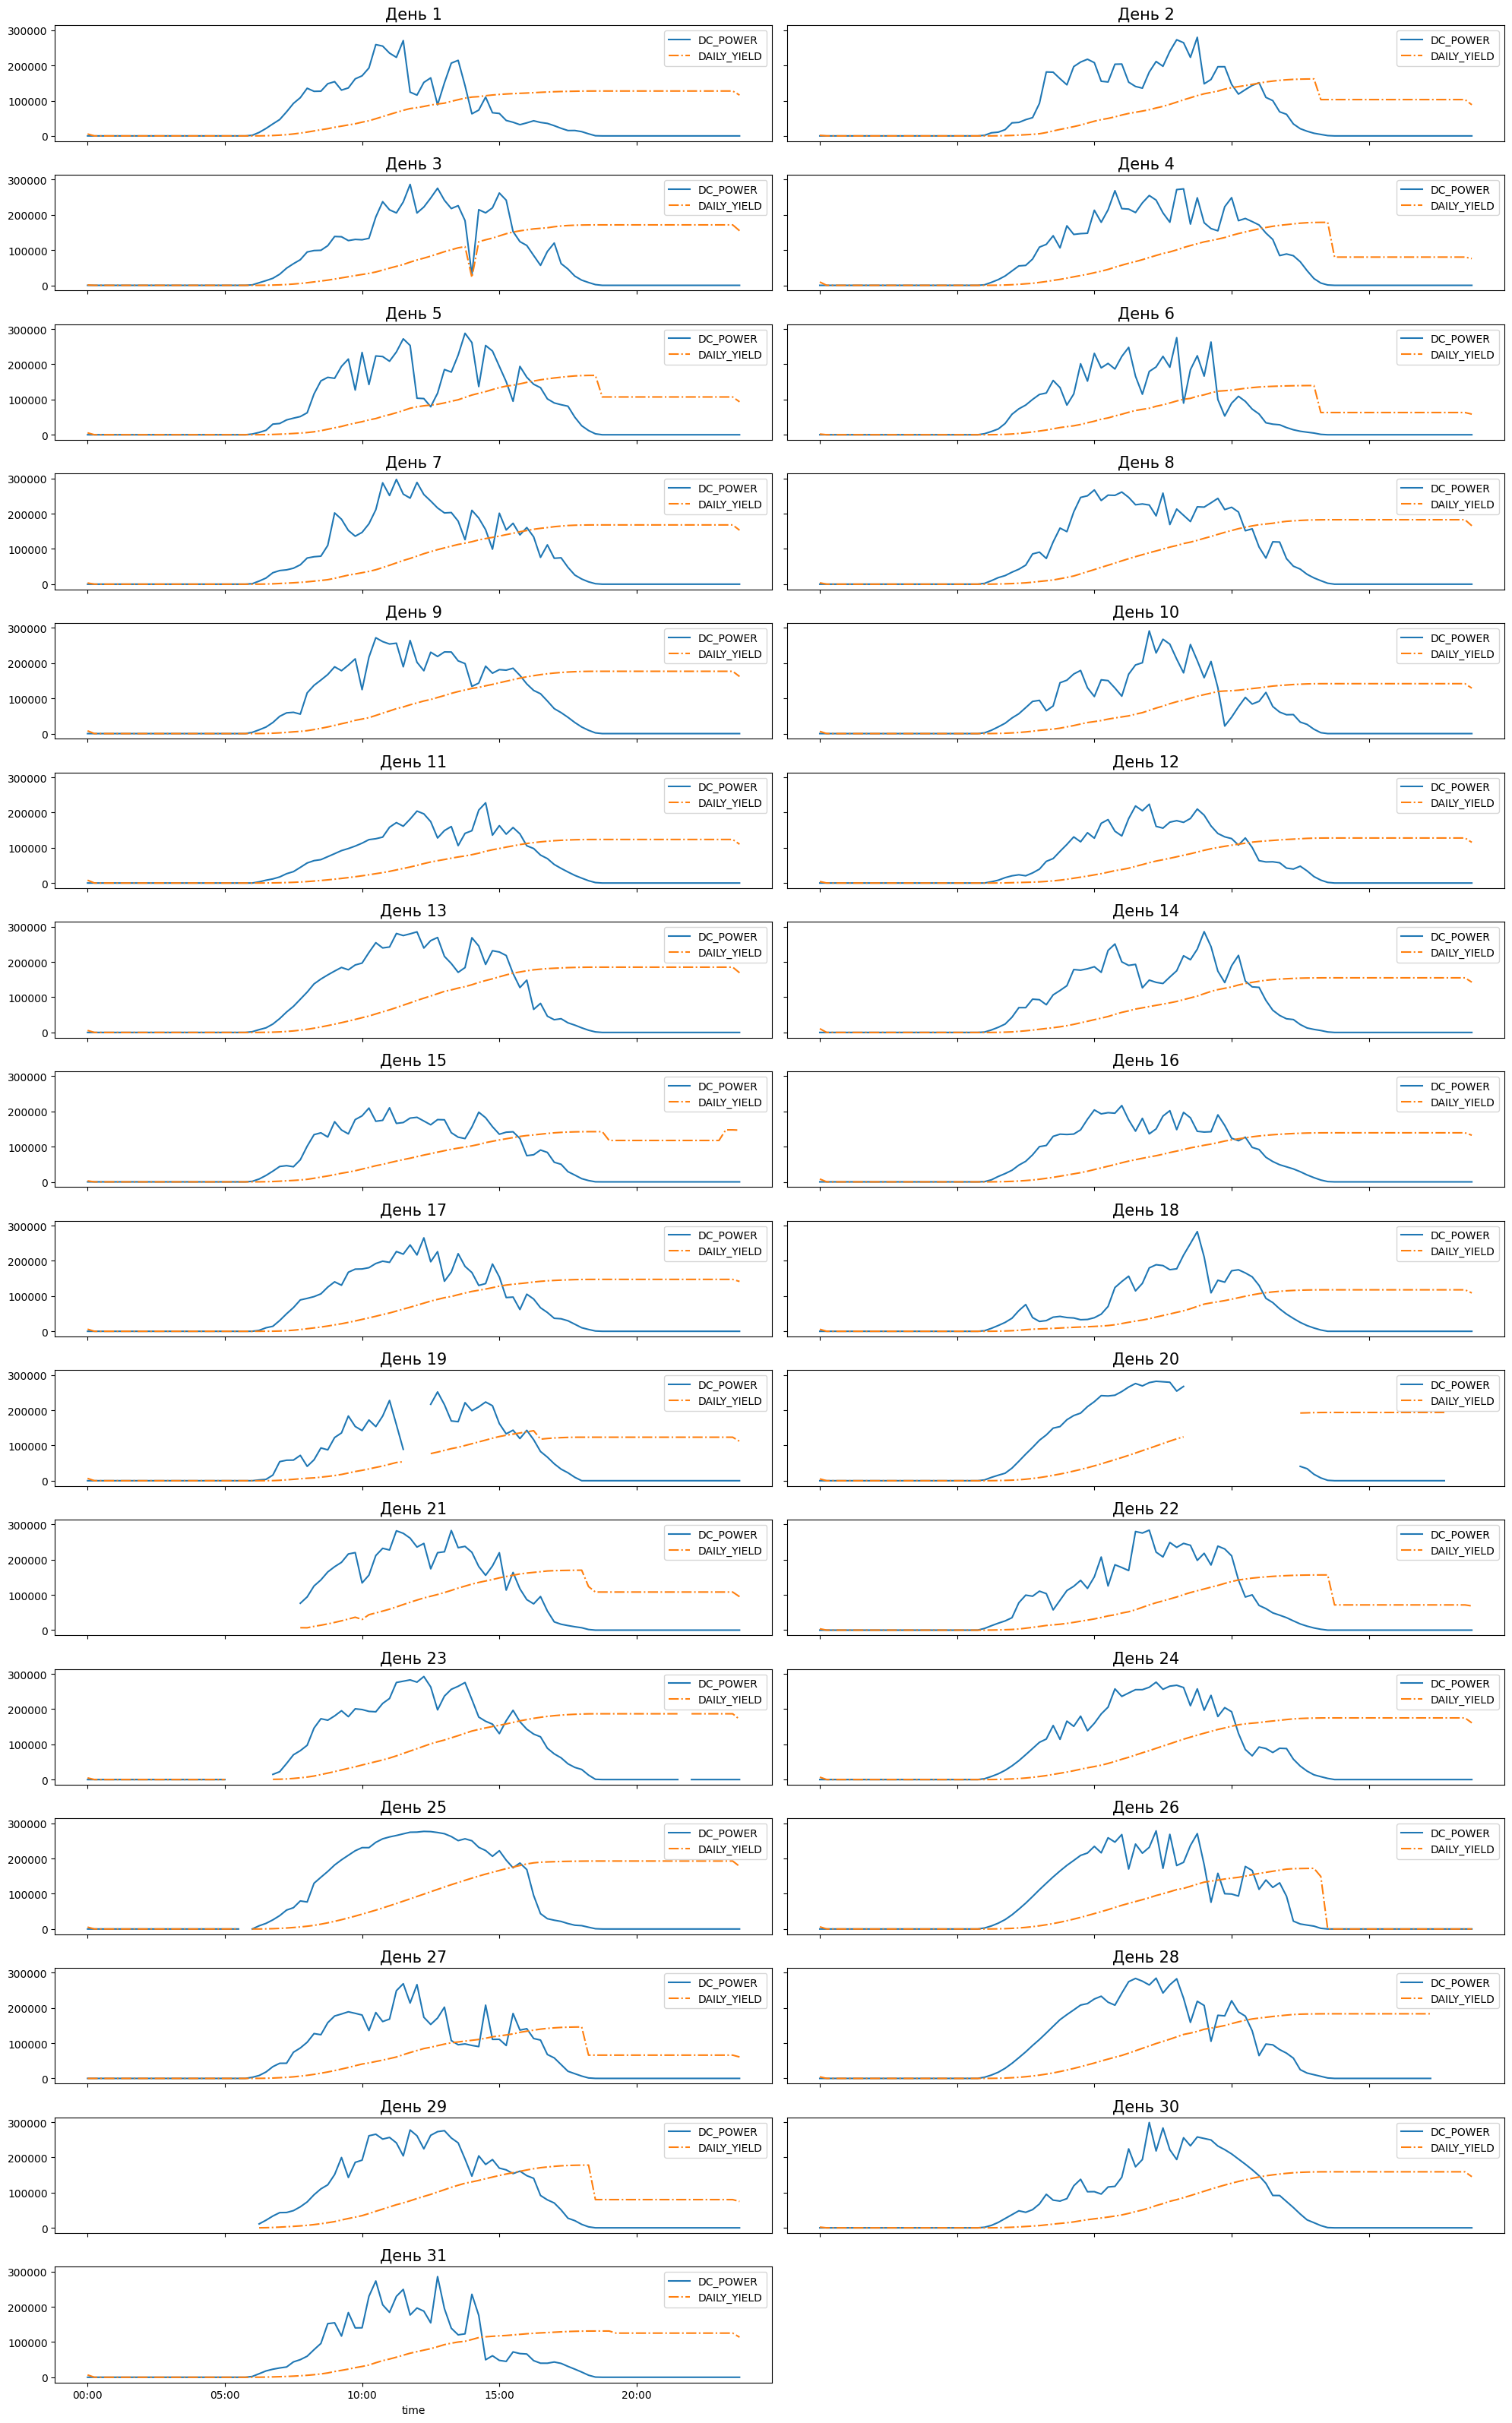

In [12]:
data = plant1_data[['DC_POWER', 'DAILY_YIELD', 'day', 'time']]


dc_power_plot = data.groupby(['time', 'day'])['DC_POWER'].mean().unstack()
daily_yield_plot = data.groupby(['time', 'day'])['DAILY_YIELD'].mean().unstack()


num_days = dc_power_plot.shape[1]  # Число столбцов = число дней
rows = (num_days + 1) // 2  # Автоматический расчет строк для (rows x 2) сетки


fig, ax = plt.subplots(nrows=rows, ncols=2, figsize=(20, rows * 2), sharex=True, sharey=True)


ax = ax.flatten()


for i, day in enumerate(dc_power_plot.columns):
    dc_power_plot[day].plot(ax=ax[i], legend=False, label='DC_POWER')
    daily_yield_plot[day].plot(ax=ax[i], legend=False, linestyle='-.', label='DAILY_YIELD')

    ax[i].set_title(f'День {day}', size=15)
    ax[i].legend(['DC_POWER', 'DAILY_YIELD'])

for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()

На 19-21 дни есть длительное отсутствие значений. Скорее всего были неполадки и солнечные батареи не работали.

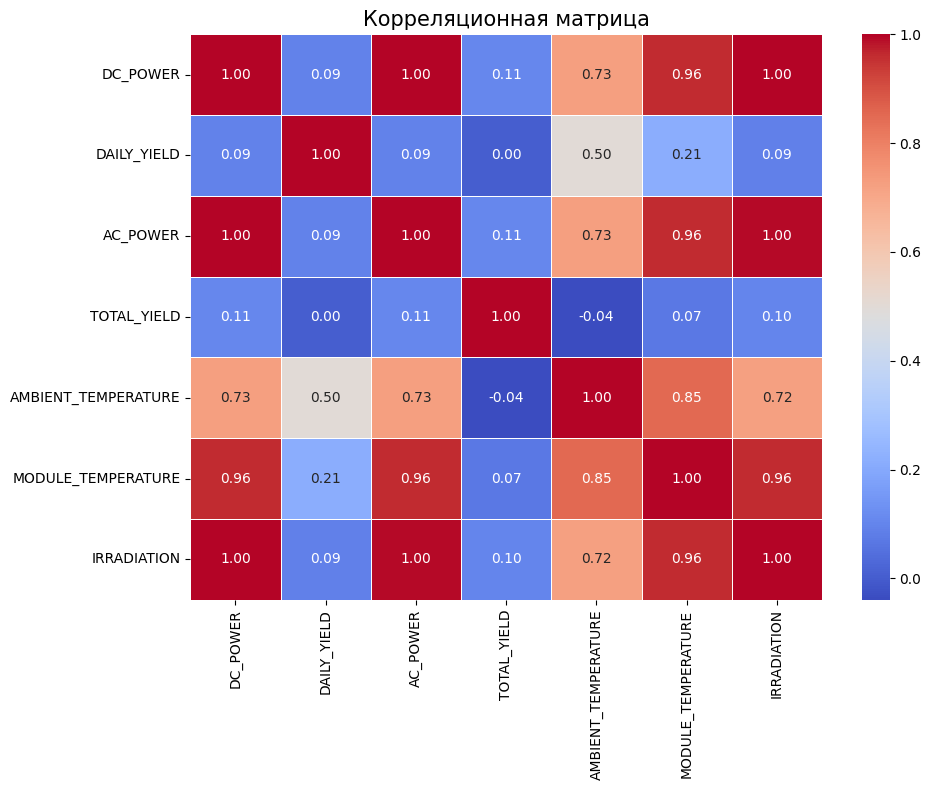

In [13]:
data = plant1_data[['DC_POWER', 'DAILY_YIELD', 'AC_POWER', 'TOTAL_YIELD', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]
correlation_matrix = data.corr()


plt.figure(figsize=(10, 8)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)


plt.title('Корреляционная матрица', fontsize=15)

plt.tight_layout()
plt.show()

Заметна корреляция температуры окружающей среды и суммой сгенерированной энергии. Очевидна сильная корреляция между AC и DC. Также сильная корреляция у температуры модуля и радиации с другими столбцами.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='DAILY_YIELD', ylabel='Count'>

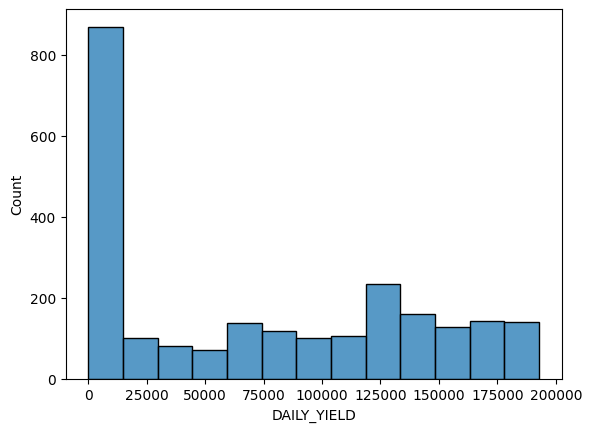

In [47]:
sns.histplot(plant1_data['DAILY_YIELD'])

In [14]:
plant1_data['hour'] = plant1_data["DATE_TIME"].dt.hour
plant1_data['month'] = plant1_data["DATE_TIME"].dt.month
plant1_data['is_night'] = ((plant1_data['hour'] >= 0) & (plant1_data['hour'] <= 6)).astype(int)

plant1_data['lag_1'] = plant1_data['DAILY_YIELD'].shift(1) # 15 мин
plant1_data['lag_4'] = plant1_data['DAILY_YIELD'].shift(4) # 1 час
plant1_data['lag_96'] = plant1_data['DAILY_YIELD'].shift(96) # 1 день
plant1_data['lag_672'] = plant1_data['DAILY_YIELD'].shift(672) # 1 неделя

plant1_data['rolling_mean_4'] = plant1_data['DAILY_YIELD'].rolling(window=4).mean()
plant1_data['rolling_mean_96'] = plant1_data['DAILY_YIELD'].rolling(window=96).mean()
plant1_data['rolling_std_96'] = plant1_data['DAILY_YIELD'].rolling(window=96).std()
plant1_data['rolling_min_96'] = plant1_data['DAILY_YIELD'].rolling(window=96).min()
plant1_data['rolling_max_96'] = plant1_data['DAILY_YIELD'].rolling(window=96).max()

plant1_data['dc_lag_1'] = plant1_data['DC_POWER'].shift(1) # 15 мин
plant1_data['dc_lag_4'] = plant1_data['DC_POWER'].shift(4) # 1 час
plant1_data['dc_lag_96'] = plant1_data['DC_POWER'].shift(96) # 1 день
plant1_data['dc_lag_672'] = plant1_data['DC_POWER'].shift(672) # 1 неделя

plant1_data['dc_rolling_mean_4'] = plant1_data['DC_POWER'].rolling(window=4).mean()
plant1_data['dc_rolling_mean_96'] = plant1_data['DC_POWER'].rolling(window=96).mean()
plant1_data['dc_rolling_std_96'] = plant1_data['DC_POWER'].rolling(window=96).std()
plant1_data['dc_rolling_min_96'] = plant1_data['DC_POWER'].rolling(window=96).min()
plant1_data['dc_rolling_max_96'] = plant1_data['DC_POWER'].rolling(window=96).max()

plant1_data['rad_lag_1'] = plant1_data['IRRADIATION'].shift(1) # 15 мин
plant1_data['rad_lag_4'] = plant1_data['IRRADIATION'].shift(4) # 1 час
plant1_data['rad_lag_96'] = plant1_data['IRRADIATION'].shift(96) # 1 день
plant1_data['rad_lag_672'] = plant1_data['IRRADIATION'].shift(672) # 1 неделя

plant1_data['rad_rolling_mean_4'] = plant1_data['IRRADIATION'].rolling(window=4).mean()
plant1_data['rad_rolling_mean_96'] = plant1_data['IRRADIATION'].rolling(window=96).mean()
plant1_data['rad_rolling_std_96'] = plant1_data['IRRADIATION'].rolling(window=96).std()
plant1_data['rad_rolling_min_96'] = plant1_data['IRRADIATION'].rolling(window=96).min()
plant1_data['rad_rolling_max_96'] = plant1_data['IRRADIATION'].rolling(window=96).max()


plant1_data.dropna(inplace=True)
plant1_data.set_index('DATE_TIME',inplace=True)
plant1_data

,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,day,time,hour,...,dc_rolling_max_96,rad_lag_1,rad_lag_4,rad_lag_96,rad_lag_672,rad_rolling_mean_4,rad_rolling_mean_96,rad_rolling_std_96,rad_rolling_min_96,rad_rolling_max_96
DATE_TIME,,,,,,,,,,,,,,,,,,,,,
2020-05-22 16:15:00,61082.535716,5992.028571,151285.214288,1.519893e+08,30.797410,37.025922,0.195134,22,16:15,16,...,283826.62500,0.223404,0.468398,0.239683,0.0,0.270794,0.231170,0.314822,0.0,1.047775
2020-05-22 16:30:00,49037.875001,4807.937500,152624.410715,1.519906e+08,30.207747,34.962585,0.156285,22,16:30,16,...,283826.62500,0.195134,0.346550,0.301570,0.0,0.223228,0.229657,0.314829,0.0,1.047775
2020-05-22 16:45:00,42450.035714,4161.191072,153765.803570,1.519918e+08,29.846668,33.622705,0.135876,22,16:45,16,...,283826.62500,0.156285,0.318087,0.165297,0.0,0.177675,0.229351,0.314907,0.0,1.047775
2020-05-22 17:00:00,35424.017857,3467.873214,154708.910715,1.519927e+08,29.571082,32.477741,0.113217,22,17:00,17,...,283826.62500,0.135876,0.223404,0.070541,0.0,0.150128,0.229795,0.314710,0.0,1.047775
2020-05-22 17:15:00,26301.160715,2558.055357,155486.232142,1.519935e+08,29.301833,31.361377,0.083773,22,17:15,17,...,283826.62500,0.113217,0.195134,0.050017,0.0,0.122288,0.230147,0.314526,0.0,1.047775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-17 22:45:00,0.000000,0.000000,129571.000000,1.561428e+08,22.150570,21.480377,0.000000,17,22:45,22,...,297928.39287,0.000000,0.000000,0.000000,0.0,0.000000,0.176403,0.252201,0.0,1.031230
2020-06-17 23:00:00,0.000000,0.000000,129571.000000,1.561428e+08,22.129816,21.389024,0.000000,17,23:00,23,...,297928.39287,0.000000,0.000000,0.000000,0.0,0.000000,0.176403,0.252201,0.0,1.031230
2020-06-17 23:15:00,0.000000,0.000000,129571.000000,1.561428e+08,22.008275,20.709211,0.000000,17,23:15,23,...,297928.39287,0.000000,0.000000,0.000000,0.0,0.000000,0.176403,0.252201,0.0,1.031230


In [15]:
plant1_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2388 entries, 2020-05-22 16:15:00 to 2020-06-17 23:45:00
Data columns (total 39 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DC_POWER             2388 non-null   float64
 1   AC_POWER             2388 non-null   float64
 2   DAILY_YIELD          2388 non-null   float64
 3   TOTAL_YIELD          2388 non-null   float64
 4   AMBIENT_TEMPERATURE  2388 non-null   float64
 5   MODULE_TEMPERATURE   2388 non-null   float64
 6   IRRADIATION          2388 non-null   float64
 7   day                  2388 non-null   int32  
 8   time                 2388 non-null   object 
 9   hour                 2388 non-null   int32  
 10  month                2388 non-null   int32  
 11  is_night             2388 non-null   int64  
 12  lag_1                2388 non-null   float64
 13  lag_4                2388 non-null   float64
 14  lag_96               2388 non-null   float64
 15  la

В реальных задачах не будут известны значения DAILY YIELD, DC энергии и радиации в будущем. Поэтому разумно использовать лаги и скользящие окна за предыдущие промежутки времени. 

Прогнозируемую температуру можно легко получить из  API

Полезными могут оказаться признаки часа и ночи, тк энергия генерируется только при солнце.

Месяц не будет полезным, тк имеются данные только за май и июнь.

# Тренировка моделей

# Линейные модели

In [16]:
cols = ['AMBIENT_TEMPERATURE', 'DAILY_YIELD', 'hour', 'is_night',
        'lag_1', 'lag_4', 'lag_96', 'lag_672',
        'rolling_mean_4', 'rolling_mean_96', 'rolling_std_96', 
        'rolling_min_96', 'rolling_max_96',
        'dc_lag_1', 'dc_lag_4', 'dc_lag_96', 'dc_lag_672',
        'dc_rolling_mean_4', 'dc_rolling_mean_96', 'dc_rolling_std_96', 
        'dc_rolling_min_96', 'dc_rolling_max_96',
        'rad_lag_1', 'rad_lag_4', 'rad_lag_96', 'rad_lag_672',
        'rad_rolling_mean_4', 'rad_rolling_mean_96', 'rad_rolling_std_96', 
        'rad_rolling_min_96', 'rad_rolling_max_96']
data = plant1_data[cols]

In [17]:
X = data.drop(['DAILY_YIELD'], axis=1)
y = data['DAILY_YIELD']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False)

In [19]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

# Оценка точности
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae:.2f}')
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse:.2f}')

MAE: 5194.21
MSE: 108308747.24


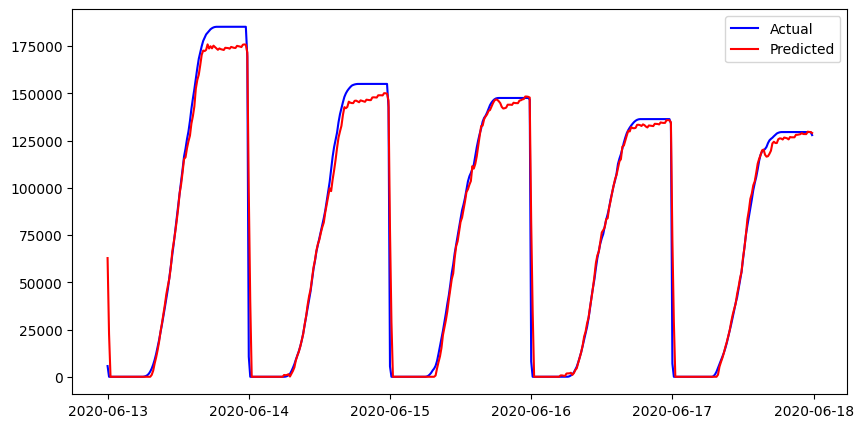

In [26]:
plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label="Actual", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted", color="red")
plt.legend()
plt.show()

In [23]:
y_pred[y_pred < 0] = 0

In [25]:
# Оценка точности
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae:.2f}')
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse:.2f}')

MAE: 3635.39
MSE: 81566530.32


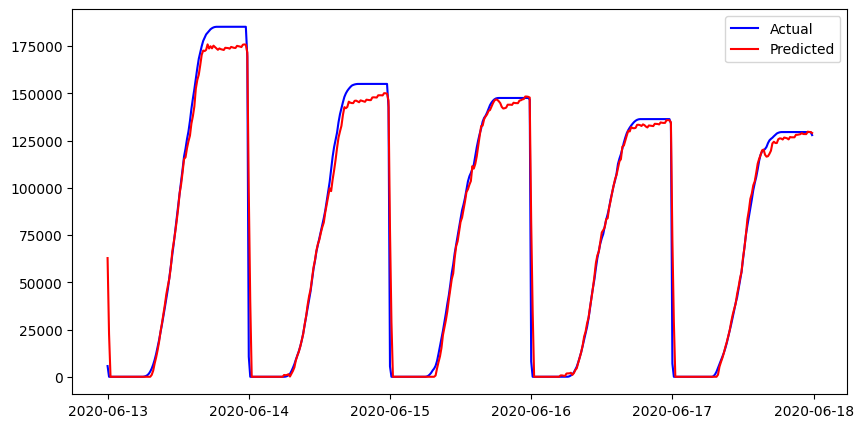

In [24]:
plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label="Actual", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted", color="red")
plt.legend()
plt.show()

In [31]:
model = Ridge(alpha=4)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

# Оценка точности
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae:.2f}')

mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse:.2f}')

MAE: 4916.76
MSE: 105256419.26


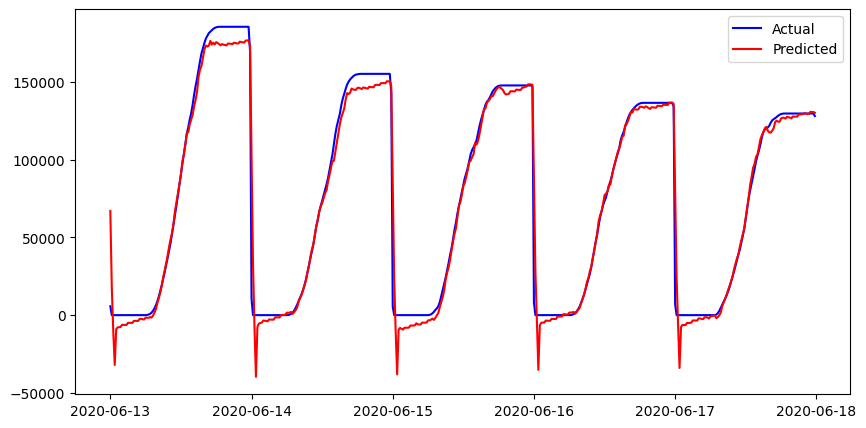

In [32]:
plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label="Actual", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted", color="red")
plt.legend()
plt.show()

In [33]:
y_pred[y_pred < 0] = 0

# Оценка точности
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae:.2f}')
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse:.2f}')

MAE: 3522.07
MSE: 85901956.89


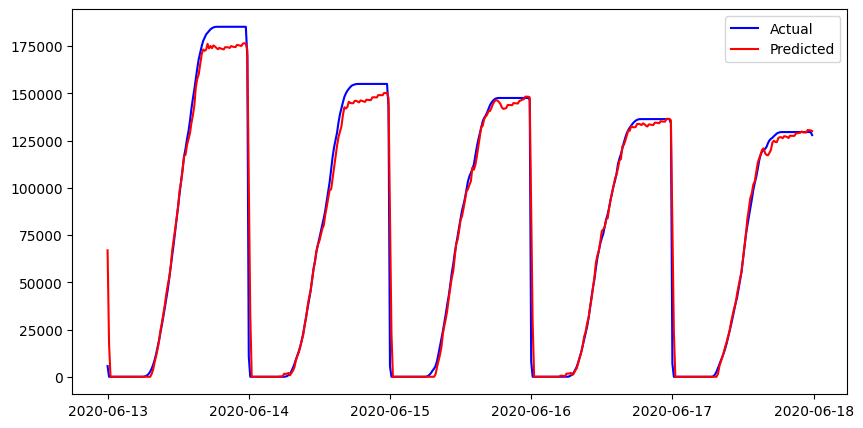

In [34]:
plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label="Actual", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted", color="red")
plt.legend()
plt.show()

In [41]:
model = Lasso(alpha=35)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

# Оценка точности
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae:.2f}')

mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse:.2f}')

MAE: 4392.40
MSE: 103000254.19


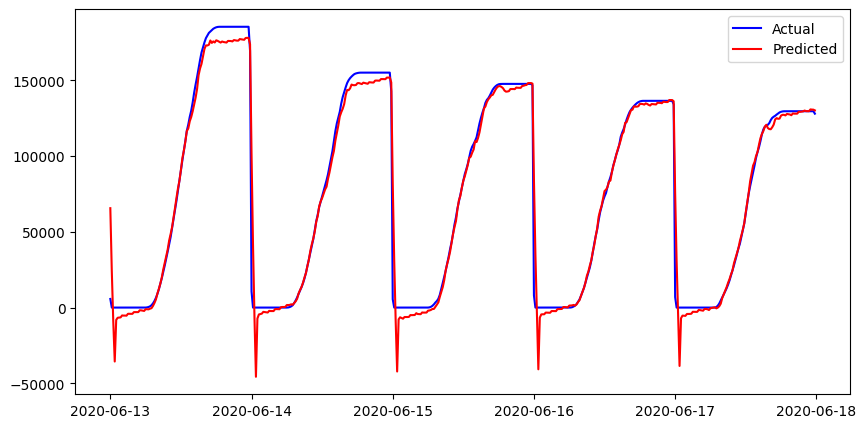

In [42]:
plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label="Actual", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted", color="red")
plt.legend()
plt.show()

In [43]:
y_pred[y_pred < 0] = 0

# Оценка точности
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae:.2f}')
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse:.2f}')

MAE: 3155.24
MSE: 81792841.79


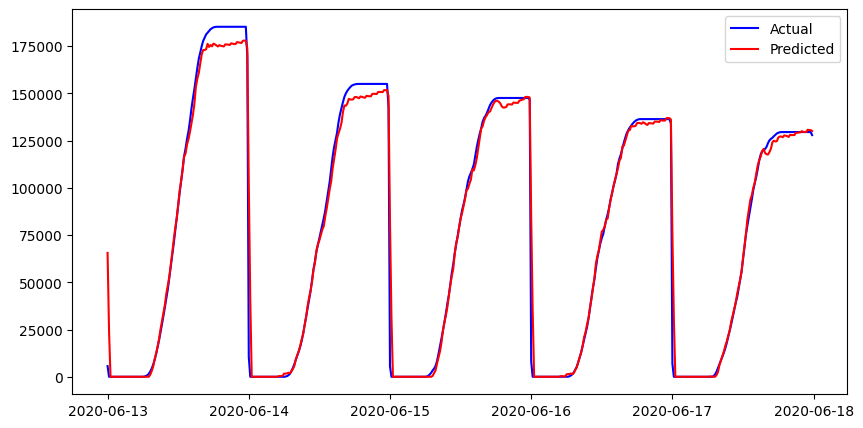

In [44]:
plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label="Actual", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted", color="red")
plt.legend()
plt.show()

# Другие модели

In [136]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

# Оценка точности
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae:.2f}')
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse:.2f}')

MAE: 662.62
MSE: 2058488.59


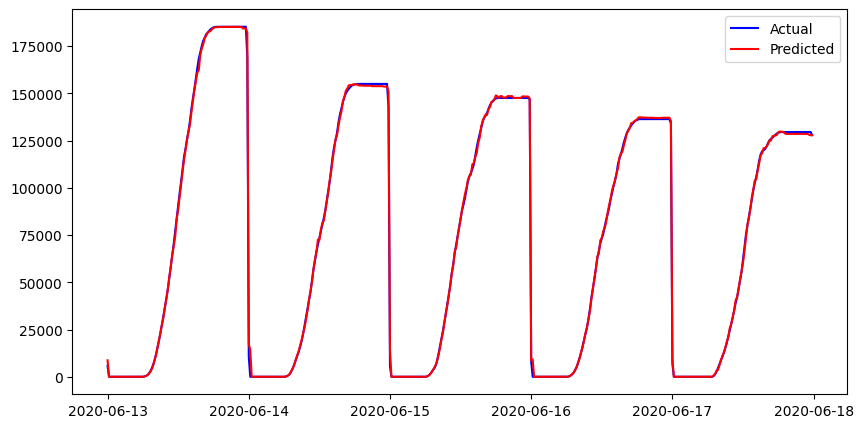

In [137]:
plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label="Actual", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted", color="red")
plt.legend()
plt.show()

In [138]:
model = CatBoostRegressor(iterations=3000, loss_function='RMSE', random_seed=42)
model.fit(X_train_scaled, y_train, plot=True)

y_pred = model.predict(X_test_scaled)

# Оценка точности
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae:.2f}')
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse:.2f}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.018564
0:	learn: 65429.8903492	total: 4.9ms	remaining: 14.7s
1:	learn: 64313.1180685	total: 9.18ms	remaining: 13.8s
2:	learn: 63237.0645044	total: 12.9ms	remaining: 12.9s
3:	learn: 62185.4558709	total: 16.8ms	remaining: 12.6s
4:	learn: 61133.4312380	total: 20.8ms	remaining: 12.4s
5:	learn: 60071.8299511	total: 24.7ms	remaining: 12.3s
6:	learn: 59035.0400245	total: 28.6ms	remaining: 12.2s
7:	learn: 58061.9841051	total: 32.7ms	remaining: 12.2s
8:	learn: 57079.4483142	total: 36.4ms	remaining: 12.1s
9:	learn: 56189.8759598	total: 40.5ms	remaining: 12.1s
10:	learn: 55294.7000186	total: 44.3ms	remaining: 12.1s
11:	learn: 54365.8223216	total: 48.2ms	remaining: 12s
12:	learn: 53478.3089709	total: 51.8ms	remaining: 11.9s
13:	learn: 52608.4190297	total: 55.8ms	remaining: 11.9s
14:	learn: 51705.2895413	total: 59.8ms	remaining: 11.9s
15:	learn: 50841.8635317	total: 63.3ms	remaining: 11.8s
16:	learn: 49990.8953349	total: 67.1ms	remaining: 11.8s
17:	learn: 49155.3397230	total:

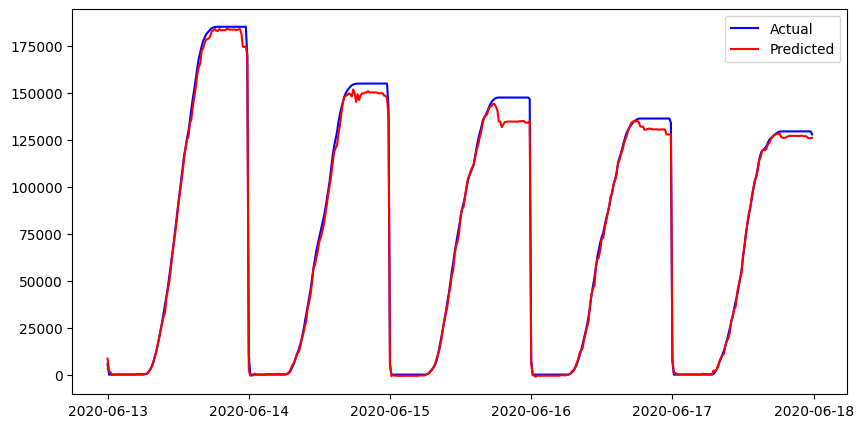

In [139]:
plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label="Actual", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted", color="red")
plt.legend()
plt.show()

# ARIMA

In [87]:
data = plant_1_generation.groupby('DATE_TIME').sum()
data = data['DAILY_YIELD'][-96*12:].reset_index()
data.set_index('DATE_TIME',inplace=True)
data

,DAILY_YIELD
DATE_TIME,
2020-06-05 23:30:00,107249.000000
2020-06-05 23:45:00,93497.642857
2020-06-06 00:00:00,2000.821429
2020-06-06 00:15:00,0.000000
2020-06-06 00:30:00,0.000000
...,...
2020-06-17 22:45:00,129571.000000
2020-06-17 23:00:00,129571.000000
2020-06-17 23:15:00,129571.000000


In [88]:
result = adfuller(data["DAILY_YIELD"])

test_statistic = result[0]
p_value = result[1]
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")

Test Statistic: -7.8662111031586734
P-value: 5.1266227647160655e-12


In [89]:
result = kpss(data["DAILY_YIELD"])

test_statistic = result[0]
p_value = result[1]
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")

Test Statistic: 0.0454795449580765
P-value: 0.1


<ipython-input-89-bb2c9b325802>:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(data["DAILY_YIELD"])


Используя статистики предполагаем что данные стационарны, значит коэффициент d равен 0

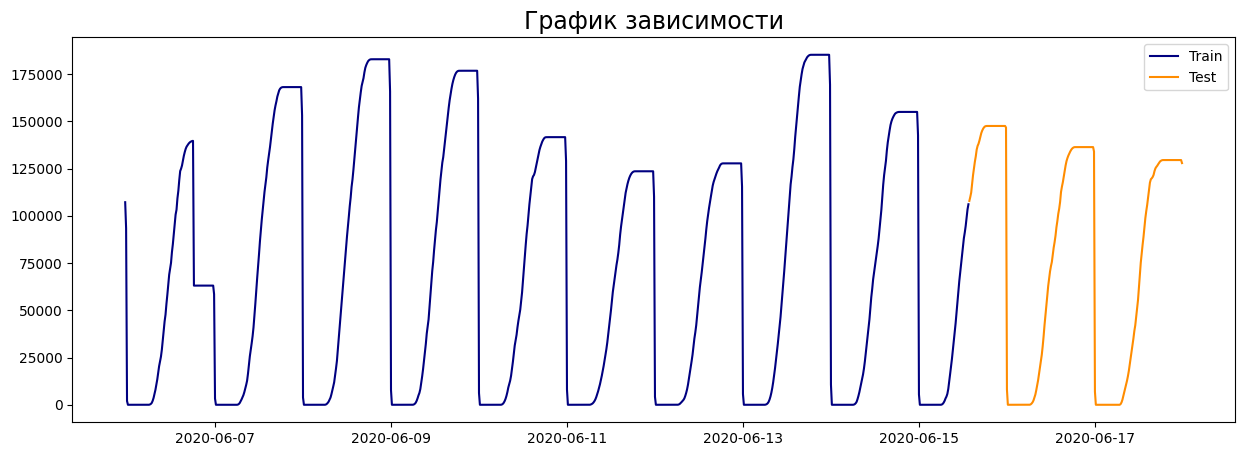

In [90]:
TEST_SIZE = 0.2
train_len = int(data.size * (1 - TEST_SIZE))
train_data = data[:train_len]
test_data = data[train_len:]

plt.figure(figsize=(15,5))
plt.plot(train_data,label='Train',color='navy')
plt.plot(test_data,label='Test',color='darkorange')
plt.title('График зависимости',fontsize=17)
plt.legend()
plt.show()

Предполагаем, что есть дневная сезонность, Что равно 96 значениям по 15 минут

In [91]:
import itertools
import math

# Define the range of values for p, d, q, P, D, Q, and m
p_values = range(0, 3)  # Autoregressive order
d_values = [0]          # Differencing order
q_values = range(0, 3)  # Moving average order
P_values = range(0, 2)  # Seasonal autoregressive order
D_values = range(0, 1)  # Seasonal differencing order
Q_values = range(0, 2)  # Seasonal moving average order
m_values = [96]         # Seasonal period

# Create all possible combinations of SARIMA parameters
param_combinations = list(itertools.product(p_values, 
                                            d_values, 
                                            q_values, 
                                            P_values, 
                                            D_values, 
                                            Q_values, 
                                            m_values))

# Initialize AIC with a large value
best_aic = float("inf")  
best_params = None

# Perform grid search
for params in param_combinations:
    order = params[:3]
    seasonal_order = params[3:]
    
    try:
        model = SARIMAX(train_data, 
                        order=order, 
                        seasonal_order=seasonal_order)
        result = model.fit(disp=False)
        aic = result.aic
        
        # Ensure the convergence of the model
        if not math.isinf(result.zvalues.mean()):
            print(order, seasonal_order, aic)
        
            if aic < best_aic:
                best_aic = aic
                best_params = params
                
        else:
            print(order, seasonal_order, 'not converged')

    except:
        continue

# Print the best parameters and AIC
print("Best Parameters:", best_params)
print("Best AIC:", best_aic)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting paramet

(0, 0, 0) (0, 0, 0, 96) 23783.08471797743
(0, 0, 0) (0, 0, 1, 96) 23254.202347729395


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)


(0, 0, 0) (1, 0, 0, 96) 21526.658972723788


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)


(0, 0, 0) (1, 0, 1, 96) 21643.334068799606
(0, 0, 1) (0, 0, 0, 96) 23120.293337739186


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequen

(0, 0, 1) (0, 0, 1, 96) 23004.900065240385


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 1) (1, 0, 0, 96) 22953.51542573892


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 1) (1, 0, 1, 96) 22951.10349632284


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 2) (0, 0, 0, 96) 22948.539755023587


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(0, 0, 2) (0, 0, 1, 96) 22912.119652519512


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 2) (1, 0, 0, 96) 22896.028307836896


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 2) (1, 0, 1, 96) 22893.756010789257
(1, 0, 0) (0, 0, 0, 96) 20198.74785744958


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting paramet

(1, 0, 0) (0, 0, 1, 96) 19477.158194889376


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)


(1, 0, 0) (1, 0, 0, 96) 18500.742801405268


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)


(1, 0, 0) (1, 0, 1, 96) 18608.23938775142
(1, 0, 1) (0, 0, 0, 96) 20172.893968174125


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting paramet

(1, 0, 1) (0, 0, 1, 96) 19700.488436987


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)


(1, 0, 1) (1, 0, 0, 96) 18508.412231306807


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 1) (1, 0, 1, 96) 18456.33635665656


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)


(1, 0, 2) (0, 0, 0, 96) 20173.471742838854


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(1, 0, 2) (0, 0, 1, 96) 19703.546368505056


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 2) (1, 0, 0, 96) 18488.18203205585


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 2) (1, 0, 1, 96) 18456.484086864417
(2, 0, 0) (0, 0, 0, 96) 20170.407784728322


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting paramet

(2, 0, 0) (0, 0, 1, 96) 19458.21349232293


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)


(2, 0, 0) (1, 0, 0, 96) 18486.21251952425


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  

(2, 0, 1) (0, 0, 0, 96) 20172.849417898433


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(2, 0, 1) (0, 0, 1, 96) 19700.158327691002


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dat

(2, 0, 1) (1, 0, 0, 96) not converged


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 1) (1, 0, 1, 96) 19194.403230108564


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)


(2, 0, 2) (0, 0, 0, 96) 20165.376823693536


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 2) (0, 0, 1, 96) 19698.70785338262


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn

(2, 0, 2) (1, 0, 1, 96) 19454.66090336819
Best Parameters: (1, 0, 1, 1, 0, 1, 96)
Best AIC: 18456.33635665656


In [92]:
model = SARIMAX(train_data,
                order=best_params[:3],
                seasonal_order=best_params[3:])
result = model.fit(disp=False)

# Show the summary
result.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        DAILY_YIELD   No. Observations:                  921
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 96)   Log Likelihood               -9223.168
Date:                            Sat, 15 Mar 2025   AIC                          18456.336
Time:                                    07:23:31   BIC                          18480.464
Sample:                                06-05-2020   HQIC                         18465.543
                                     - 06-15-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9713      0.005    198.272      0.000       0.962       0.981
ma.L1          0.1292      0.024      5.360      0.000       0.082       0.176
ar.S.L96       0.9691      0.002    620.973      0.000       0.966       0.972
ma.S.L96      -0.3498      0.007    -51.949      0.000      -0.363      -0.337
sigma2      2.398e+07   7.03e-10   3.41e+16      0.000     2.4e+07     2.4e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            975419.53
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                            -4.58
Prob(H) (two-sided):                  0.00   Kurtosis:                       162.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.17e+31. Standard errors may be unstable.
"""

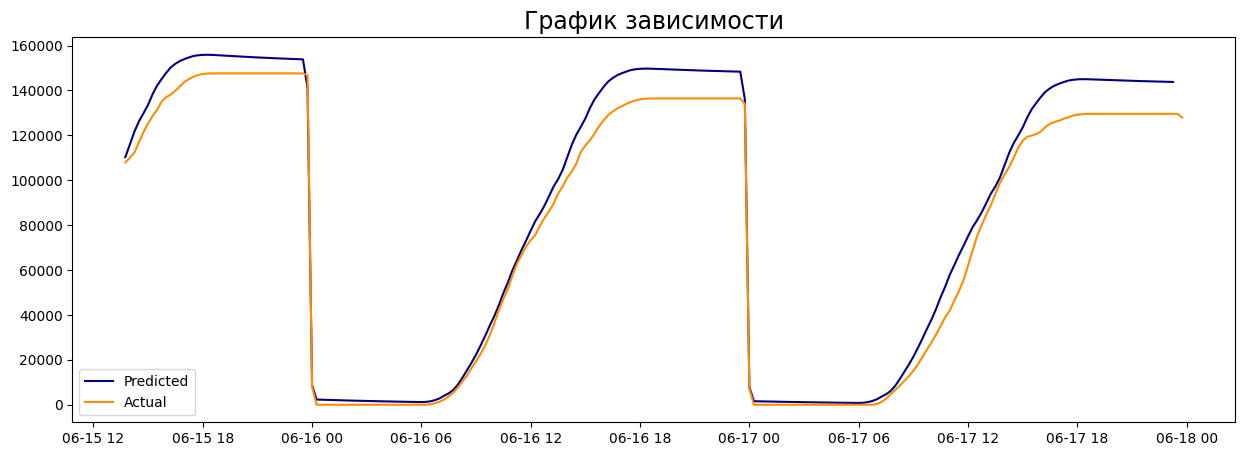

In [93]:
forecast = result.get_forecast(steps=test_data.size)
y_pred = forecast.predicted_mean

plt.figure(figsize=(15,5))
plt.plot(y_pred, label='Predicted',color='navy')
plt.plot(test_data, label='Actual',color='darkorange')
plt.title('График зависимости',fontsize=17)
plt.legend()
plt.show()

In [94]:
mae = mean_absolute_error(test_data, y_pred)
print(f'MAE: {mae:.2f}')

mse = mean_squared_error(test_data, y_pred)
print(f'MSE: {mse:.2f}')

MAE: 6831.37
MSE: 74897022.32


### Материалы

https://mlpills.dev/time-series/how-to-train-a-sarima-model-step-by-step/ <br>
https://catboost.ai/docs/en/ <br>
https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html#statsmodels.tsa.statespace.sarimax.SARIMAX <br>
https://chatgpt.com/share/67d14c34-d668-8001-9e9d-1d8ea059d6ac <br>
https://education.yandex.ru/handbook/ml/article/vremennye-ryady <br>
https://education.yandex.ru/handbook/ml/article/modeli-vida-arima